In [632]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from ipywidgets import FloatProgress
from IPython.display import display

import numpy as np
import time

from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score
from collections import defaultdict


from pypf.tree import ShapeletTreeClassifier
from sklearn.ensemble import BaggingClassifier

from pypf._utils import print_tree

from pypf.sliding_distance import matches, min_distance
import matplotlib.pylab as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [633]:
def transform_shape(s, x, i, theta):
    x_match = x[i:(i + s.shape[0])]
    v = x_match - s
    norm_v = np.linalg.norm(v)
    if norm_v == 0:
        return s
    else:
        return s - v / norm_v * theta

In [705]:
train = np.loadtxt("data/TwoLeadECG_TRAIN", delimiter=",")
x = train[:, 1:]
y = train[:, 0]

test = np.loadtxt("data/TwoLeadECG_TEST", delimiter=",")
x_test = test[:, 1:]
y_test = test[:, 0]
print(x.shape)

(23, 82)


In [706]:
tmp = defaultdict(list)
for i, label in enumerate(y):
    tmp[label].append(i)

label_index = {label:np.array(arr) for label, arr in tmp.items()}

In [707]:
tree = ShapeletTreeClassifier(n_shapelets=100, scale=False)
bag = BaggingClassifier(base_estimator=tree, random_state=10, n_estimators=100, n_jobs=8)
bag.fit(x, y)

BaggingClassifier(base_estimator=ShapeletTreeClassifier(max_depth=2147483648, min_samples_leaf=2,
            n_shapelets=100,
            random_state=<mtrand.RandomState object at 0x7fad6f543b40>,
            scale=False),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=100, n_jobs=8, oob_score=False,
         random_state=10, verbose=0, warm_start=False)

In [708]:
bag.score(x_test, y_test)

0.922739244951712

In [709]:
def extract_paths(node, d, classes_, path):
    if node.is_leaf:
        d[classes_[np.argmax(node.proba)]].append(path)
    else:
        left_path = path.copy()
        left_path.append(("<=", node.shapelet.array, node.threshold))
        extract_paths(node.left, d, classes_, left_path)
        
        right_path = path.copy()
        right_path.append((">", node.shapelet.array, node.threshold))
        extract_paths(node.right, d, classes_, right_path)


In [710]:
paths = defaultdict(list)
for base_estimator in bag.estimators_:
    extract_paths(base_estimator.root_node_, paths, bag.classes_, [])

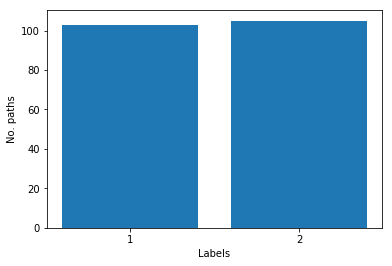

In [711]:
label, p_count = zip(*[(label, len(path)) for label, path in paths.items()])
plt.bar(label, p_count)
plt.xlabel("Labels")
plt.xticks(label)
plt.ylabel("No. paths")
plt.show()

In [712]:
def transform_with_path(x, path, epsilon=0.05):
    steps = []
    for direction, shapelet, threshold in path:
        if direction == "<=":
            distance, location = min_distance(shapelet, x, return_index=True)
            if distance > threshold:
                impute_shape = transform_shape(shapelet, x, location, threshold - epsilon)
                x[location:(location+len(shapelet))] = impute_shape
                steps.append(x.copy())
        else:
            locations = matches(shapelet, x, threshold)
            if len(locations) > 0:
                for location in locations:
                    impute_shape = transform_shape(shapelet, x, location, threshold + epsilon)
                    x[location:(location + len(shapelet))] = impute_shape
                    steps.append(x.copy())
    return x, steps

Convert 19 from 1.0 to 2


FloatProgress(value=0.0, max=105.0)

Path 22 has lowest cost: 1.6136092333091159


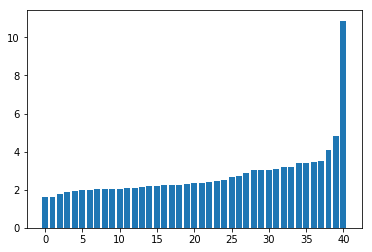

In [714]:
to_label = 2
from_label = 1
example = label_index[from_label][-1]
x_i = x[example, :]
min_cost = np.inf
min_i = -1
x_prime = None
print("Convert", example, "from", y[example], "to", to_label)
path_list = paths[to_label]

f = FloatProgress(min=0, max=len(path_list))
display(f)
x_prime = np.empty([len(path_list), x.shape[1]])
step_prime = np.empty(len(path_list), dtype=object)
for i, path in enumerate(path_list):
    x_i_prime, steps = transform_with_path(x_i.copy(), path, epsilon=0.05)
    x_prime[i, :] = x_i_prime
    step_prime[i] = steps
    f.value = i

y_prime = bag.predict(x_prime)
x_prime = x_prime[y_prime == to_label]
step_prime = step_prime[y_prime == to_label]
cost = np.linalg.norm(x_prime - x_i, axis=1) 
min_cost_i = np.argmin(cost)
min_x = x_prime[min_cost_i, :]
min_cost = cost[min_cost_i]
if min_cost_i >= 0:
    print("Path", min_cost_i, "has lowest cost:", min_cost )
    plt.bar(np.arange(cost.shape[0]), np.sort(cost))
else:
    print("No possible transformation")

In [715]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(1)
neigh.fit(x[y == to_label])


NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=1, p=2, radius=1.0)

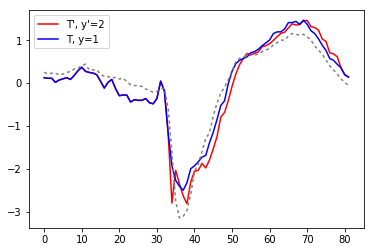

In [716]:
def plot_example(ax, x_i, min_x, closest):
    ax.plot(min_x, c="red", label="T', y'={}".format(to_label))
    ax.plot(x_i, c="blue", label="T, y={}".format(from_label))
    for i in range(closest.shape[1]):
        ax.plot(x[y == to_label][closest[0, i]], c="gray", dashes=[2, 2])

closest = neigh.kneighbors(min_x.reshape(1, -1), return_distance=False)
fig, ax = plt.subplots(1)
plot_example(ax, x_i, min_x, closest)
plt.legend()
plt.savefig("figure/example1.pdf")

In [717]:
cost_sort = np.argsort(cost)

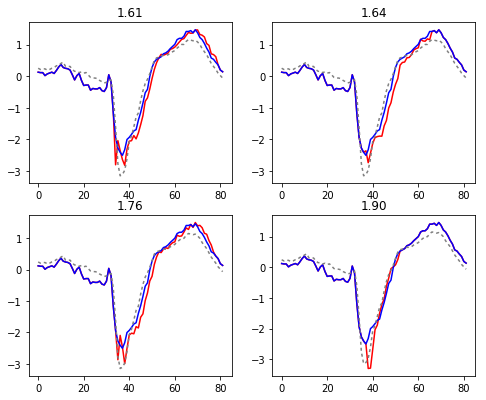

In [718]:
fig = plt.figure(figsize=(8, 6.5))
ax = fig.subplots(2, 2)
for i, a in enumerate(ax.reshape(-1)):
    x_cost_i = x_prime[cost_sort[i], :]
    closest = neigh.kneighbors(x_cost_i.reshape(1, -1), return_distance=False)
    plot_example(a, x_i, x_cost_i, closest)
    a.set_title("{:.2f}".format(cost[cost_sort[i]]))
fig.savefig("figure/example2.pdf")

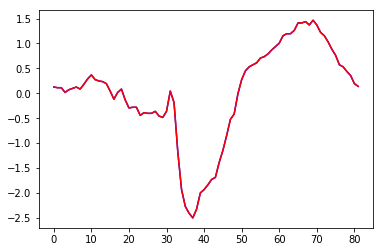

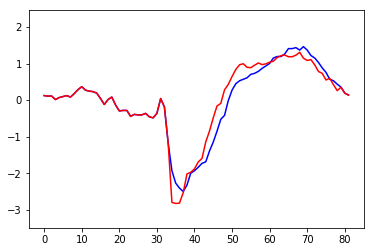

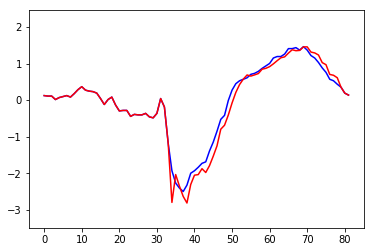

In [722]:
steps = step_prime[cost_sort[0]]
plt.figure()
plt.plot(x_i, c="blue")
plt.plot(x_i, c="red")
for step in steps:
    plt.figure()
    plt.plot(x_i, c="blue")
    plt.ylim([np.min(x_i)-np.std(x_i), np.max(x_i)+np.std(x_i)])
    plt.plot(step, c="red")